# 1. Extract data

- We are using single-cell RNA seq data from [Notaras M, Lodhi A, Dündar F, et al. Schizophrenia is defined by cell-specific neuropathology and multiple neurodevelopmental mechanisms in patient-derived cerebral organoids. Mol Psychiatry. 2021;10.1038/s41380-021-01316-6. doi:10.1038/s41380-021-01316-6](https://www.nature.com/articles/s41380-021-01316-6)
- For each sample, add prefix to cell barcode to all BAM files and all barcodes.tsv.gz. Example: C1, C2, KO1, KO2. Processing BAM file can be done using functions `has_tag()` and `set_tag()` in `pysam`.
- For each sample, split BAM file into smaller files by chromosome name. This step can be done by using function `view` by `samtools`.
- For each chromosome, merge BAM files from all samples into one BAM file. This step can be done by using function `merge` by `samtools`.
- For each chromosome, exclude reads whose cell barcodes are not in barcodes.tsv.gz from BAM files. Follow instructions given by Cell Ranger https://kb.10xgenomics.com/hc/en-us/articles/360022448251-How-to-filter-the-BAM-file-produced-by-10x-pipelines-with-a-list-of-barcodes-
- Finally, generate three files of 100, 500, 1000 UTRs whose each UTR have at least 20.000 reads in the following steps
    - Execute gen_utr_annotation and prepare_input 
    - Search for UTRs with more than 20.000 reads from derived input pickle files using `pickle` and save position of those qualified UTRs in an CSV file
    - Convert derived CSV file to a bed file in `bash command`
    ```bash
    cat /.../data/list_utr_1000.csv | tr ',' '\t' > /.../data/list_utr_1000.bed
    ```
    - Extract selected positions from BAM files using `samtools`
    ```bash
    samtools view -b -h -L /.../data/list_utr_100.bed /.../data/final_all.bam > /.../data/rerun_utr_100.bam
    samtools index /.../data/rerun_utr_100.bam
    ```

# 2. Inferring PA sites

To compare the performance between different version correctly, we used then same infrastructure set up when executing slurm jobs:
- Memory: 10Gb
- Number of node: 1
- Node list: pe[81]

We also used the same annotation file and barcode file for both versions.

```bash
## ========================================================
## new SCAPE
## execute the following commands for different BAM files: rerun_utr_100.bam, rerun_utr_500.bam, rerun_utr_1000.bam
scape gen_utr_annotation \
    --gff_file Homo_sapiens.GRCh38.98.chr.gff3.gz \
    --output_dir /.../data/new \
    --res_file_name GRCh38_98 \
    --gff_merge_strategy merge

scape prepare_input \
    --utr_file /.../data/new/GRCh38_98.csv \
    --cb_file /.../data/new/barcodes.tsv.gz \
    --bam_file /.../data/new/rerun_utr_100.bam \
    --output_dir /.../data/new \
    --chunksize 100
    
python -m scape infer_pa \
--pkl_input_file /.../pkl_input/input_bam.100.1.1.input.pkl \
--output_dir /.../data/new

scape merge_pa \
--output_dir /.../data/new \
--utr_merge False

scape ex_pa_cnt_mat \
--output_dir /.../data/new \
--res_pkl_file res.utr.pkl
```

```bash
## ========================================================
## old scape
## execute the following commands for different BAM files: rerun_utr_100.bam, rerun_utr_500.bam, rerun_utr_1000.bam
python /old-scape/SCAPE/main.py prepare \
        --gtf /.../GrCh38-from-cellranger/sorted_genes_cellranger_GrCh38_2020.gtf.gz \
        --prefix GRCh38

python /old-scape/SCAPE/main.py apamix \
        --bed GRCh38_utr.bed \
        --bam /.../data/rerun_utr_100.bam \
        --out rerun_100/ \
        --cb /.../data/barcodes.tsv.gz
```

Then write the outputs to CSV files

```python
## ========================================================
### Processing the result from new SCAPE
import pickle
import pandas as pd
import numpy as np

chrom = []
gene = []
utr_st =[]
utr_en =[]
strand = []
alpha = []
beta = []
weight_cal = []
weight = []
fi = []
for i in ['bam100', 'bam500', 'bam1000', 'bam2000']:
    path = '/.../data/new/'+i+'/res.utr.pkl'
    with open(path, 'rb') as f:
        while True:
            try:
                l = pickle.load(f)
                gene_info = l.gene_info_str.split(':')
                pa_lst = list(l.alpha_arr)
                beta_lst = list(l.beta_arr)
                w_lst = list(l.ws)
                label_lst = list(l.label_arr)
                length = len(pa_lst)
                for idx in range(length):
                    pa = pa_lst[idx]
                    b = beta_lst[idx]
                    w = w_lst[idx]
                    chrom.append(gene_info[0])
                    gene.append(gene_info[1])
                    utr_st.append(int(gene_info[3].split('-')[0]))
                    utr_en.append(int(gene_info[3].split('-')[1]))
                    strand.append(gene_info[4])
                    alpha.append(int(pa))
                    beta.append(float(b))
                    weight.append(sum(np.array(label_lst) == idx))
                    weight_cal.append(float(w))
                    fi.append(i)
            except EOFError:
                break

df = pd.DataFrame({'file':fi, 'chrom':chrom, 'alpha_rel':alpha, 'strand':strand, 'utr_st':utr_st, 'utr_en':utr_en
                  , 'beta':beta, 'weight':weight, 'gene': gene
                   , 'weight_cal':weight_cal
                  })
df['alpha'] = 0
df.loc[df['strand']=='-', 'alpha']=df.loc[df['strand']=='-', 'utr_en'] - df.loc[df['strand']=='-', 'alpha_rel'] + 1
df.loc[df['strand']=='+', 'alpha']=df.loc[df['strand']=='+', 'utr_st'] + df.loc[df['strand']=='+', 'alpha_rel']
df.to_csv('/.../data/new/result_utr.csv', index=False)
```

```python
## ========================================================
## Processing result from the old SCAPE
import pandas as pd
import os 
path = '/.../data/old'
lst = [i for i in os.listdir('/.../data/old')]
done = []

chrom = []
strand = []
alpha = []
beta = []
weight = []
fi = []
for i in done:
    na = i.split('_')
    j = '/.../data/old/pkl_output/'+i+'/pasite.csv.gz'
    df = pd.read_csv(j, compression='gzip')
    for pa in df['Unnamed: 0'].tolist():
        pa_ = pa.split(':')
        chrom.append(pa_[0])
        alpha.append(pa_[1])
        beta.append(pa_[2])
        strand.append(pa_[3])
        fi.append(na[0])
        weight.append(df.loc[df['Unnamed: 0']==pa,[i for i in df.columns if i != 'Unnamed: 0']].sum(axis='columns').values[0])

df = pd.DataFrame({'file':fi, 'crhom':chrom, 'alpha':alpha, 'strand':strand, 'beta':beta, 'weight':weight
                  })

df.to_csv('/.../data/old/result.csv', index=False)
```

```python
## ========================================================
## Join two results
old=pd.read_csv('/.../data/old/result.csv')
new=pd.read_csv('/.../data/new/result.csv')
tmp=old.groupby('utr')['alpha'].count()
old['K'] = tmp[old['utr']].values
tmp=new.groupby('utr')['alpha'].count()
new['K'] = tmp[new['utr']].values

df= new.merge(old, on='utr', suffixes=('_new', '_old'))
df['diff'] = abs(df['alpha_new'] - df['alpha_old'])
df.loc[df.groupby(['utr','alpha_new'])['diff'].idxmin()].to_csv('/your-scape/examples/benchmark-comparison/join_pa_new.csv', index=False)

```

# Benchmark comparison

The comparison in execution time is done on three BAM files, while comparison in SCAPE output (alpha, beta, weight) were done on BAM file of 1000 UTRs. Following steps are for generating comparison in SCAPE output.

Data is provided in `examples/benchmark-comparison/join_pa_new.csv` downloaded from github page  [chengl7-la/scape/examples/benchmark-comparison](https://github.com/chengl7-lab/scape/tree/main/examples)

In [2]:
library(magrittr)
library(ggplot2); theme_set(theme_bw(base_size = 16))
library(data.table)
library(openxlsx)
library(tidyverse)

In [3]:
df <- fread('/your-scape/examples/benchmark-comparison/join_pa_new.csv')
tmp <- df %>% group_by(alpha_old, alpha_new) %>% summarise(n=length(utr))
get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}
df$alpha_dens <- get_density(df$alpha_old, df$alpha_new, n=100)
df$beta_dens <- get_density(df$beta_old, df$beta_new, n=100)
df$w_dens <- get_density(df$w_old, df$w_new, n=100)

`summarise()` has grouped output by 'alpha_old'. You can override using the
`.groups` argument.


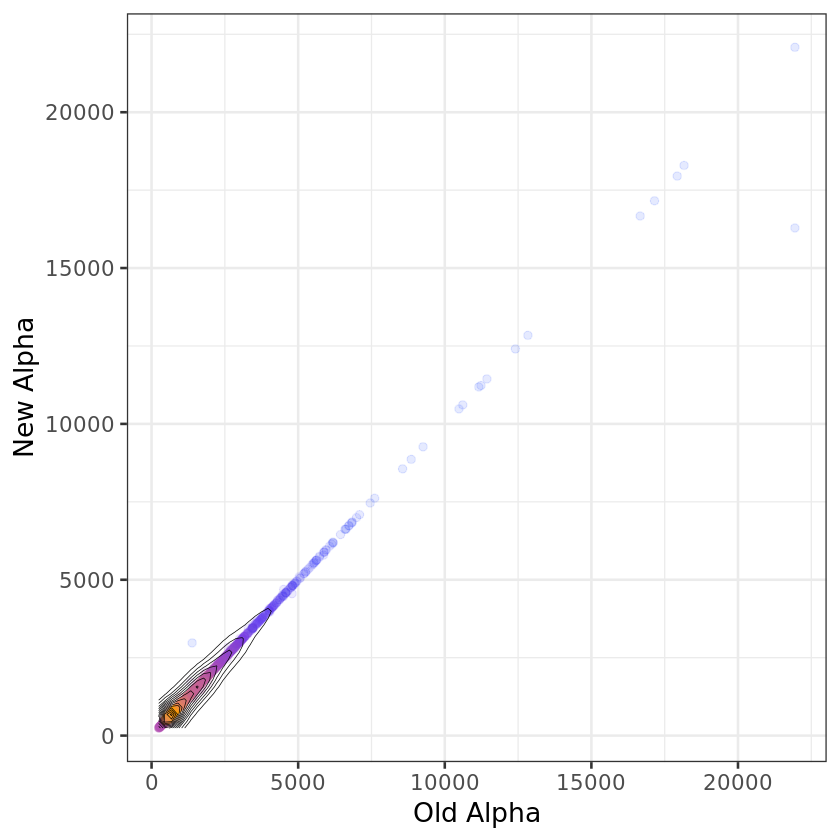

In [4]:
## Comparison in Alpha
ggplot(data=df, aes(x=alpha_old, y=alpha_new)) +
geom_point(alpha=0.1, size=2, aes(color = alpha_dens))  + 
scale_colour_gradient(low='#0033ff', high='orange') +
geom_density_2d(color='black', bins=15, linewidth=0.2)+
    xlab("Old Alpha") + ylab("New Alpha") +
    theme(legend.position='none')


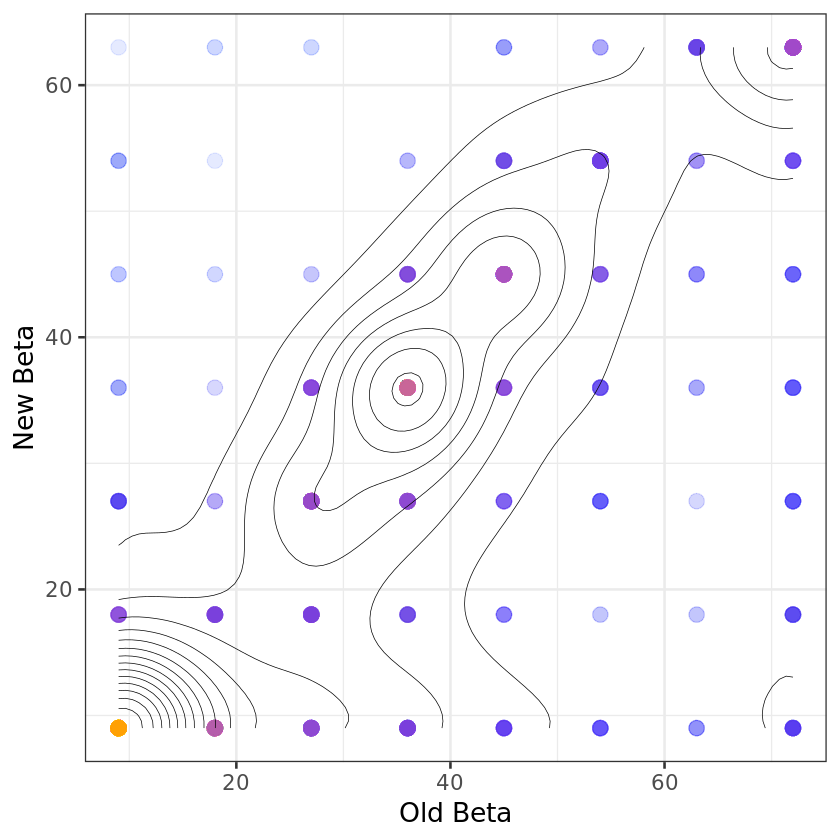

In [5]:
## Comparison in Beta
ggplot(data=df, aes(x=beta_old, y=beta_new)) +
geom_point(alpha=0.1, size=4, aes(color = beta_dens))  + 
scale_colour_gradient(low='#0033ff', high='orange') +
geom_density_2d(color='black', bins=15, linewidth=0.2)+
    xlab("Old Beta") + ylab("New Beta") +
    theme(legend.position='none')


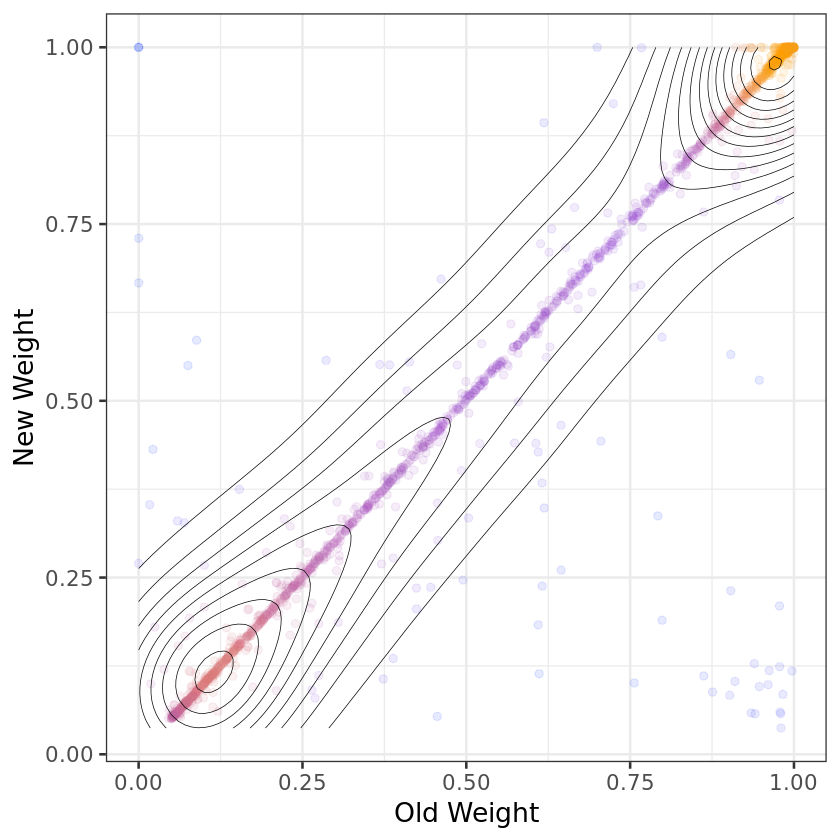

In [6]:
## Comparison in Weight
ggplot(data=df, aes(x=w_old, y=w_new)) +
geom_point(alpha=0.1, size=2, aes(color = w_dens))  + 
scale_colour_gradient(low='#0033ff', high='orange') +
geom_density_2d(color='black', bins=15, linewidth=0.2)+
    xlab("Old Weight") + ylab("New Weight") +
    theme(legend.position='none')


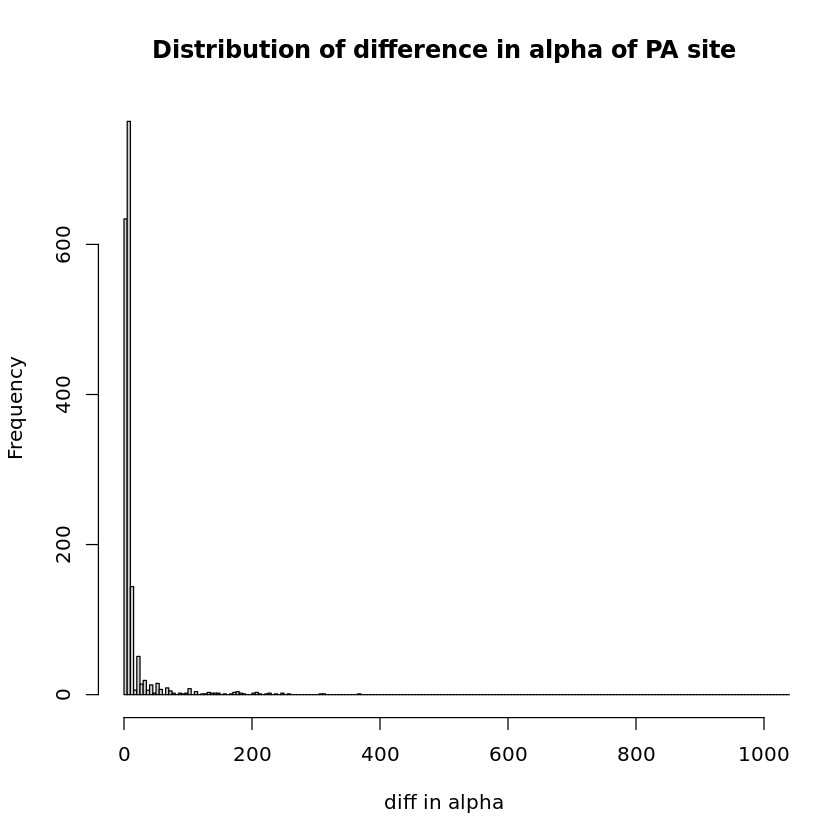

In [7]:
hist(df$diff, breaks=1000, xlim=c(0,1000), xlab='diff in alpha', main="Distribution of difference in alpha of PA site")